In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

In [2]:
import prepare_data
import imp
imp.reload(prepare_data)

<module 'prepare_data' from '/home/ubuntu/CarND-Vehicle-Detection/src/prepare_data.py'>

In [3]:
d, car_list, notcar_list = prepare_data.data_look()

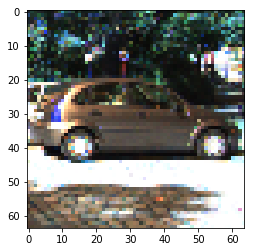

In [4]:
c_image = car_list[10]
plt.imshow(cv2.imread(c_image))

In [5]:
image = mpimg.imread('../test_images/test1.jpg')
print(image.shape)

(720, 1280, 3)


In [6]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
def classify_car(car_list, notcar_list):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, 656] # Min and max in y to search in slide_window()


    car_features = extract_features(car_list, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcar_list, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    """
    # Check the prediction time for a single sample
    t=time.time()

    image = mpimg.imread('../test_images/test1.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.25, 0.25))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    """
    
    return svc, car_features, notcar_features, X_scaler

In [10]:
from sklearn.svm import LinearSVC

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes = []
    count = 0
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print("Spacial features shape ::: {0}".format(spatial_features.shape))
            #print("Hist features shape ::: {0}".format(hist_features.shape))
            #print("Hog features shape ::: {0}".format(hog_features.shape))
            all_features = np.hstack((spatial_features, hist_features, hog_features))
            #print("All features shape ::: {0}".format(all_features.shape))
            # Scale features and make a prediction
            test_features = X_scaler.transform(all_features[:4932])
            test_features = test_features.reshape(1, -1)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
                count+=1    
                if count>0:
                        boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, boxes, count

In [11]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
import random
d, car_list, notcar_list = prepare_data.data_look()
notcar_list = [ notcar_list[i] for i in sorted(random.sample(range(len(notcar_list)), len(car_list))) ]
print("Training set cars size ::::: {0}".format(len(car_list)))
print("Training set not cars size :::: {0}".format(len(notcar_list)))
svc, car_features, notcar_features, X_scaler = classify_car(car_list, notcar_list)

Training set cars size ::::: 5966
Training set not cars size :::: 5966


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
10.2 Seconds to train SVC...
Test Accuracy of SVC =  0.995


Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dis

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

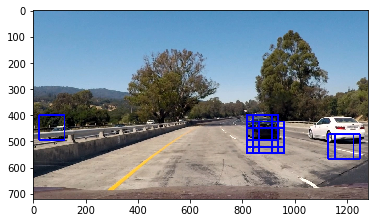

In [12]:
img = mpimg.imread('../test_images/test1.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255
scale = 1.5
ystart = 400
ystop = 656
img_tosearch = img[400:656,:,:]
print("Test Image Shape ::: {0}".format(img.shape))
print("Image to search shape :::: {0}".format(img_tosearch.shape))
img, boxes, count = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(img)

In [13]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [14]:
def find_cars_multiple(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #Bom scales = [1.1,1.4, 1.8, 2.2, 2.7, 3.2]
    scales = [1.1,1.4, 1.8, 2.4, 2.9, 3.4]
    
    c=0
    bbox = []           
    for scale in scales:
        c+=1
        #The first half of scales is valid for the upper half of image
        if c<len(scales):
            ystartaux = ystart
            ystopaux = int((ystart+ystop)/2)
        else:
            ystartaux = int((ystart+ystop)/2)
            ystopaux = ystop

        img, box, count = find_cars(img, ystartaux, ystopaux, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if count>0:
            for b in box:
                bbox.append(b)
    return bbox

In [15]:
img = mpimg.imread('../test_images/test1.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255
scale = 1.5
ystart = 400
ystop = 656
cspace = 'YCrCb'
img_tosearch = img[400:656,:,:]
print("Test Image Shape ::: {0}".format(img.shape))
print("Image to search shape :::: {0}".format(img_tosearch.shape))
bbox2 = find_cars_multiple(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)



Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dis

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [16]:
print(bbox2)

[((52, 400), (122, 470)), ((809, 400), (879, 470)), ((809, 417), (879, 487)), ((827, 435), (897, 505)), ((862, 417), (932, 487)), ((862, 435), (932, 505)), ((880, 417), (950, 487)), ((1073, 400), (1143, 470)), ((1091, 400), (1161, 470)), ((1108, 400), (1178, 470)), ((1161, 400), (1231, 470)), ((22, 400), (111, 489)), ((89, 400), (178, 489)), ((112, 400), (201, 489)), ((761, 400), (850, 489)), ((784, 400), (873, 489)), ((806, 400), (895, 489)), ((828, 400), (917, 489)), ((851, 400), (940, 489)), ((873, 400), (962, 489)), ((896, 400), (985, 489)), ((1030, 400), (1119, 489)), ((1052, 400), (1141, 489)), ((1075, 400), (1164, 489)), ((1097, 400), (1186, 489)), ((1120, 400), (1209, 489)), ((1142, 400), (1231, 489)), ((1164, 400), (1253, 489))]


In [17]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    b_heat = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        b_heat.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return the image
    return img, b_heat


In [18]:
# Add heat to each box in box list
def get_heat_map(img, bounding_box):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox2)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print(labels[1])
    plt.imshow(labels[0], cmap='gray')
    draw_img, b_heat = draw_labeled_bboxes(np.copy(image), labels)
    plt.imshow(draw_img)
    fig = plt.figure()
    return draw_img

#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')

4


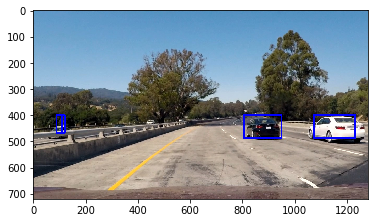

In [19]:

heat_image = mpimg.imread('../test_images/test1.jpg')
new_img = get_heat_map(heat_image, bbox2)

In [ ]:
def process_image(img):
    scale = 1.5
    ystart = 400
    ystop = 656
    cspace = 'YCrCb'
    img_tosearch = img[400:656,:,:]
    print("Test Image Shape ::: {0}".format(img.shape))
    print("Image to search shape :::: {0}".format(img_tosearch.shape))
    bbox2 = find_cars_multiple(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return get_heat_map(img, bbox2)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

output = '../out_project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")#.subclip(40,44)
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
4
[MoviePy] >>>> Building video ../out_project_video.mp4
[MoviePy] Writing video ../out_project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 1/1261 [00:00<13:11,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 2/1261 [00:01<13:15,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 3/1261 [00:01<13:14,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 4/1261 [00:02<13:16,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 5/1261 [00:03<13:15,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  0%|          | 6/1261 [00:03<13:17,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 7/1261 [00:04<13:13,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 8/1261 [00:05<13:11,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 9/1261 [00:05<13:12,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 10/1261 [00:06<13:11,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 11/1261 [00:06<13:09,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 12/1261 [00:07<13:14,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 13/1261 [00:08<13:14,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 14/1261 [00:08<13:10,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|          | 15/1261 [00:09<13:07,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|▏         | 16/1261 [00:10<13:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|▏         | 17/1261 [00:10<13:07,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  1%|▏         | 18/1261 [00:11<13:08,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 19/1261 [00:12<13:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 20/1261 [00:12<13:30,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 21/1261 [00:13<13:19,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 22/1261 [00:13<13:08,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 23/1261 [00:14<12:59,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 24/1261 [00:15<12:56,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 25/1261 [00:15<12:56,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 26/1261 [00:16<12:57,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 27/1261 [00:17<12:56,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 28/1261 [00:17<12:55,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 29/1261 [00:18<12:53,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 30/1261 [00:19<12:57,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  2%|▏         | 31/1261 [00:19<12:59,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 32/1261 [00:20<12:52,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 33/1261 [00:20<12:47,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 34/1261 [00:21<12:51,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 35/1261 [00:22<12:47,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 36/1261 [00:22<12:45,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 37/1261 [00:23<12:43,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 38/1261 [00:24<12:43,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 39/1261 [00:24<12:44,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 40/1261 [00:25<12:42,  1.60it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 41/1261 [00:25<12:46,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 42/1261 [00:26<13:20,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 43/1261 [00:27<13:17,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  3%|▎         | 44/1261 [00:27<13:08,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▎         | 45/1261 [00:28<13:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▎         | 46/1261 [00:29<12:54,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▎         | 47/1261 [00:29<12:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 48/1261 [00:30<12:53,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 49/1261 [00:31<12:49,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 50/1261 [00:31<12:47,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 51/1261 [00:32<12:43,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 52/1261 [00:32<12:44,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 53/1261 [00:33<12:43,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 54/1261 [00:34<12:44,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 55/1261 [00:34<12:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  4%|▍         | 56/1261 [00:35<12:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 57/1261 [00:36<12:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 58/1261 [00:36<12:51,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 59/1261 [00:37<12:51,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 60/1261 [00:38<12:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 61/1261 [00:38<12:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 62/1261 [00:39<12:45,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▍         | 63/1261 [00:39<12:40,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 64/1261 [00:40<13:23,  1.49it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 65/1261 [00:41<13:11,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 66/1261 [00:41<13:00,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 67/1261 [00:42<12:55,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 68/1261 [00:43<12:52,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  5%|▌         | 69/1261 [00:43<12:49,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 70/1261 [00:44<12:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 71/1261 [00:45<12:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 72/1261 [00:45<12:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 73/1261 [00:46<12:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 74/1261 [00:47<12:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 75/1261 [00:47<12:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 76/1261 [00:48<12:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 77/1261 [00:49<12:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▌         | 78/1261 [00:49<12:43,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▋         | 79/1261 [00:50<12:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▋         | 80/1261 [00:50<12:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  6%|▋         | 81/1261 [00:51<12:35,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 82/1261 [00:52<12:35,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 83/1261 [00:52<12:36,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 84/1261 [00:53<12:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 85/1261 [00:54<12:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 86/1261 [00:54<12:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 87/1261 [00:55<12:31,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 88/1261 [00:56<13:28,  1.45it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 89/1261 [00:56<13:08,  1.49it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 90/1261 [00:57<12:54,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 91/1261 [00:58<12:43,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 92/1261 [00:58<12:40,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 93/1261 [00:59<12:35,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  7%|▋         | 94/1261 [01:00<12:30,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 95/1261 [01:00<12:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 96/1261 [01:01<12:27,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 97/1261 [01:01<12:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 98/1261 [01:02<12:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 99/1261 [01:03<12:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 100/1261 [01:03<12:24,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 101/1261 [01:04<12:24,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 102/1261 [01:05<12:21,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 103/1261 [01:05<12:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 104/1261 [01:06<12:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 105/1261 [01:07<12:13,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 106/1261 [01:07<12:08,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  8%|▊         | 107/1261 [01:08<12:05,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▊         | 108/1261 [01:08<12:05,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▊         | 109/1261 [01:09<12:06,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▊         | 110/1261 [01:10<12:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 111/1261 [01:10<12:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 112/1261 [01:11<12:14,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 113/1261 [01:12<12:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 114/1261 [01:12<12:17,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 115/1261 [01:13<12:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 116/1261 [01:14<12:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 117/1261 [01:14<12:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
4


  9%|▉         | 118/1261 [01:15<13:18,  1.43it/s]

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


  9%|▉         | 119/1261 [01:16<12:58,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 120/1261 [01:16<12:42,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 121/1261 [01:17<12:26,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 122/1261 [01:18<12:17,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 123/1261 [01:18<12:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 124/1261 [01:19<12:10,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 125/1261 [01:20<12:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|▉         | 126/1261 [01:20<12:05,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 127/1261 [01:21<12:06,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 128/1261 [01:21<12:09,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 129/1261 [01:22<12:05,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 130/1261 [01:23<12:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 131/1261 [01:23<12:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 10%|█         | 132/1261 [01:24<11:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 133/1261 [01:25<12:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 134/1261 [01:25<12:05,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 135/1261 [01:26<12:04,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 136/1261 [01:27<12:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 137/1261 [01:27<12:04,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 138/1261 [01:28<12:07,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 139/1261 [01:29<12:06,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 140/1261 [01:29<12:09,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█         | 141/1261 [01:30<12:07,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█▏        | 142/1261 [01:30<12:05,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█▏        | 143/1261 [01:31<11:59,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█▏        | 144/1261 [01:32<11:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 11%|█▏        | 145/1261 [01:32<11:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 146/1261 [01:33<11:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 147/1261 [01:34<11:51,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 148/1261 [01:34<11:53,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 149/1261 [01:35<11:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 150/1261 [01:36<11:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 151/1261 [01:36<11:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 152/1261 [01:37<11:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 153/1261 [01:37<11:44,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
4


 12%|█▏        | 154/1261 [01:38<13:07,  1.41it/s]

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 155/1261 [01:39<12:43,  1.45it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 156/1261 [01:40<12:23,  1.49it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 12%|█▏        | 157/1261 [01:40<12:09,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 158/1261 [01:41<12:02,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 159/1261 [01:42<11:53,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 160/1261 [01:42<11:50,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 161/1261 [01:43<11:47,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 162/1261 [01:43<11:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 163/1261 [01:44<11:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 164/1261 [01:45<11:44,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 165/1261 [01:45<11:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 166/1261 [01:46<11:44,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 167/1261 [01:47<11:46,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 168/1261 [01:47<11:48,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 169/1261 [01:48<11:46,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 13%|█▎        | 170/1261 [01:49<11:43,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▎        | 171/1261 [01:49<11:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▎        | 172/1261 [01:50<11:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▎        | 173/1261 [01:51<11:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 174/1261 [01:51<11:42,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 175/1261 [01:52<11:35,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 176/1261 [01:52<11:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 177/1261 [01:53<11:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 178/1261 [01:54<11:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 179/1261 [01:54<11:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 180/1261 [01:55<11:26,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 181/1261 [01:56<11:23,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 14%|█▍        | 182/1261 [01:56<11:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 183/1261 [01:57<11:27,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 184/1261 [01:58<11:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 185/1261 [01:58<11:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 186/1261 [01:59<11:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 187/1261 [01:59<11:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 188/1261 [02:00<11:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▍        | 189/1261 [02:01<11:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 190/1261 [02:01<11:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 191/1261 [02:02<11:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 192/1261 [02:03<11:23,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 193/1261 [02:03<11:23,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 194/1261 [02:04<11:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 15%|█▌        | 195/1261 [02:05<11:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 196/1261 [02:05<11:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 197/1261 [02:06<11:21,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 198/1261 [02:07<12:59,  1.36it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 199/1261 [02:07<12:25,  1.42it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 200/1261 [02:08<12:04,  1.46it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 201/1261 [02:09<11:48,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 202/1261 [02:09<11:41,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 203/1261 [02:10<11:32,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▌        | 204/1261 [02:11<11:32,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▋        | 205/1261 [02:11<11:26,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▋        | 206/1261 [02:12<11:26,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▋        | 207/1261 [02:13<11:21,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 16%|█▋        | 208/1261 [02:13<11:22,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 209/1261 [02:14<11:19,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 210/1261 [02:14<11:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 211/1261 [02:15<11:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 212/1261 [02:16<11:11,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 213/1261 [02:16<11:07,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 214/1261 [02:17<11:03,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 215/1261 [02:18<11:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 216/1261 [02:18<11:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 217/1261 [02:19<11:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 218/1261 [02:20<11:03,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 219/1261 [02:20<11:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 17%|█▋        | 220/1261 [02:21<11:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 221/1261 [02:21<11:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 222/1261 [02:22<11:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 223/1261 [02:23<11:06,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 224/1261 [02:23<11:05,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 225/1261 [02:24<11:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 226/1261 [02:25<11:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 227/1261 [02:25<11:01,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 228/1261 [02:26<11:02,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 229/1261 [02:27<10:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 230/1261 [02:27<10:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 231/1261 [02:28<10:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 232/1261 [02:29<10:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 18%|█▊        | 233/1261 [02:29<10:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▊        | 234/1261 [02:30<10:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▊        | 235/1261 [02:30<10:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▊        | 236/1261 [02:31<10:59,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 237/1261 [02:32<11:00,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 238/1261 [02:32<10:59,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 239/1261 [02:33<10:57,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 240/1261 [02:34<10:56,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 241/1261 [02:34<10:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 242/1261 [02:35<10:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 243/1261 [02:36<10:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 244/1261 [02:36<10:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 19%|█▉        | 245/1261 [02:37<10:50,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 246/1261 [02:38<10:50,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 247/1261 [02:38<10:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 248/1261 [02:39<10:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 249/1261 [02:39<10:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 250/1261 [02:40<10:46,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 251/1261 [02:41<10:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|█▉        | 252/1261 [02:42<12:44,  1.32it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 253/1261 [02:42<12:08,  1.38it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 254/1261 [02:43<11:45,  1.43it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 255/1261 [02:44<11:24,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 256/1261 [02:44<11:11,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 257/1261 [02:45<11:05,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 20%|██        | 258/1261 [02:46<10:53,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 259/1261 [02:46<10:51,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 260/1261 [02:47<10:48,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 261/1261 [02:48<10:48,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 262/1261 [02:48<10:43,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 263/1261 [02:49<10:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 264/1261 [02:49<10:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 265/1261 [02:50<10:37,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 266/1261 [02:51<10:36,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██        | 267/1261 [02:51<10:35,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██▏       | 268/1261 [02:52<10:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██▏       | 269/1261 [02:53<10:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██▏       | 270/1261 [02:53<10:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 21%|██▏       | 271/1261 [02:54<10:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 272/1261 [02:55<10:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 273/1261 [02:55<10:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 274/1261 [02:56<10:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 275/1261 [02:56<10:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 276/1261 [02:57<10:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 277/1261 [02:58<10:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 278/1261 [02:58<10:32,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 279/1261 [02:59<10:32,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 280/1261 [03:00<10:33,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 281/1261 [03:00<10:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 282/1261 [03:01<10:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 22%|██▏       | 283/1261 [03:02<10:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 284/1261 [03:02<10:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 285/1261 [03:03<10:23,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 286/1261 [03:04<10:23,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 287/1261 [03:04<10:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 288/1261 [03:05<10:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 289/1261 [03:05<10:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 290/1261 [03:06<10:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 291/1261 [03:07<10:21,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 292/1261 [03:07<10:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 293/1261 [03:08<10:26,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 294/1261 [03:09<10:21,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 295/1261 [03:09<10:23,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 23%|██▎       | 296/1261 [03:10<10:21,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▎       | 297/1261 [03:11<10:18,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▎       | 298/1261 [03:11<10:17,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▎       | 299/1261 [03:12<10:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 300/1261 [03:12<10:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 301/1261 [03:13<10:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 302/1261 [03:14<10:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 303/1261 [03:14<10:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 304/1261 [03:15<10:09,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 305/1261 [03:16<10:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 306/1261 [03:16<10:08,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 307/1261 [03:17<10:07,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 24%|██▍       | 308/1261 [03:18<10:08,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 309/1261 [03:18<10:07,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 310/1261 [03:19<10:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 311/1261 [03:19<10:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 312/1261 [03:20<10:02,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 313/1261 [03:21<10:01,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 314/1261 [03:21<10:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▍       | 315/1261 [03:22<10:03,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 316/1261 [03:23<10:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 317/1261 [03:23<10:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 318/1261 [03:24<12:12,  1.29it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 319/1261 [03:25<11:35,  1.36it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 320/1261 [03:26<11:11,  1.40it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 25%|██▌       | 321/1261 [03:26<10:52,  1.44it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 322/1261 [03:27<10:39,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 323/1261 [03:28<10:26,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 324/1261 [03:28<10:17,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 325/1261 [03:29<10:12,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 326/1261 [03:30<10:09,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 327/1261 [03:30<10:04,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 328/1261 [03:31<10:02,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 329/1261 [03:31<09:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 330/1261 [03:32<10:00,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▌       | 331/1261 [03:33<09:58,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▋       | 332/1261 [03:33<09:58,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▋       | 333/1261 [03:34<09:55,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 26%|██▋       | 334/1261 [03:35<09:56,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 335/1261 [03:35<09:53,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 336/1261 [03:36<09:53,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 337/1261 [03:37<09:50,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 338/1261 [03:37<09:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 339/1261 [03:38<09:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 340/1261 [03:39<09:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 341/1261 [03:39<09:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 342/1261 [03:40<09:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 343/1261 [03:40<09:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 344/1261 [03:41<09:46,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 345/1261 [03:42<09:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 27%|██▋       | 346/1261 [03:42<09:46,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 347/1261 [03:43<09:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 348/1261 [03:44<09:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 349/1261 [03:44<09:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 350/1261 [03:45<09:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 351/1261 [03:46<09:39,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 352/1261 [03:46<09:38,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 353/1261 [03:47<09:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 354/1261 [03:47<09:35,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 355/1261 [03:48<09:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 356/1261 [03:49<09:33,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 357/1261 [03:49<09:34,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 358/1261 [03:50<09:37,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 28%|██▊       | 359/1261 [03:51<09:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▊       | 360/1261 [03:51<09:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▊       | 361/1261 [03:52<09:41,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▊       | 362/1261 [03:53<09:38,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 363/1261 [03:53<09:38,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 364/1261 [03:54<09:38,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 365/1261 [03:55<09:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 366/1261 [03:55<09:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 367/1261 [03:56<09:25,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 368/1261 [03:56<09:27,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 369/1261 [03:57<09:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 370/1261 [03:58<09:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 29%|██▉       | 371/1261 [03:58<09:25,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 372/1261 [03:59<09:24,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 373/1261 [04:00<09:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 374/1261 [04:00<09:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 375/1261 [04:01<09:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 376/1261 [04:02<09:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 377/1261 [04:02<09:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|██▉       | 378/1261 [04:03<09:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 379/1261 [04:03<09:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 380/1261 [04:04<09:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 381/1261 [04:05<09:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 382/1261 [04:05<09:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 383/1261 [04:06<09:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 30%|███       | 384/1261 [04:07<09:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 385/1261 [04:07<09:19,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 386/1261 [04:08<09:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 387/1261 [04:09<09:16,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 388/1261 [04:09<09:16,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 389/1261 [04:10<09:17,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 390/1261 [04:10<09:15,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 391/1261 [04:11<09:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 392/1261 [04:12<09:15,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 393/1261 [04:12<09:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███       | 394/1261 [04:13<09:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███▏      | 395/1261 [04:14<09:07,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███▏      | 396/1261 [04:14<09:09,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 31%|███▏      | 397/1261 [04:15<09:07,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 398/1261 [04:16<09:06,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 399/1261 [04:16<09:04,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 400/1261 [04:17<11:35,  1.24it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 401/1261 [04:18<10:49,  1.32it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 402/1261 [04:19<10:19,  1.39it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 403/1261 [04:19<09:57,  1.44it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 404/1261 [04:20<09:44,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 405/1261 [04:21<09:32,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 406/1261 [04:21<09:25,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 407/1261 [04:22<09:17,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 408/1261 [04:22<09:10,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 32%|███▏      | 409/1261 [04:23<09:05,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 410/1261 [04:24<09:03,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 411/1261 [04:24<08:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 412/1261 [04:25<08:58,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 413/1261 [04:26<08:58,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 414/1261 [04:26<08:58,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 415/1261 [04:27<08:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 416/1261 [04:28<09:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 417/1261 [04:28<08:58,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 418/1261 [04:29<08:56,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 419/1261 [04:29<08:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 420/1261 [04:30<08:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 421/1261 [04:31<08:56,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 33%|███▎      | 422/1261 [04:31<08:55,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▎      | 423/1261 [04:32<08:54,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▎      | 424/1261 [04:33<08:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▎      | 425/1261 [04:33<08:52,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 426/1261 [04:34<08:48,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 427/1261 [04:35<08:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 428/1261 [04:35<08:53,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 429/1261 [04:36<08:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 430/1261 [04:36<08:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 431/1261 [04:37<08:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 432/1261 [04:38<08:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 433/1261 [04:38<08:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 434/1261 [04:39<08:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 34%|███▍      | 435/1261 [04:40<08:42,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 436/1261 [04:40<08:41,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 437/1261 [04:41<08:40,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 438/1261 [04:42<08:39,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 439/1261 [04:42<08:39,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 440/1261 [04:43<08:41,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▍      | 441/1261 [04:43<08:40,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 442/1261 [04:44<08:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 443/1261 [04:45<08:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 444/1261 [04:45<08:45,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 445/1261 [04:46<08:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 446/1261 [04:47<08:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 35%|███▌      | 447/1261 [04:47<08:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 448/1261 [04:48<08:44,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 449/1261 [04:49<08:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 450/1261 [04:49<08:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 451/1261 [04:50<08:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 452/1261 [04:50<08:32,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 453/1261 [04:51<08:32,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 454/1261 [04:52<08:34,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 455/1261 [04:52<08:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 456/1261 [04:53<08:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▌      | 457/1261 [04:54<08:34,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▋      | 458/1261 [04:54<08:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▋      | 459/1261 [04:55<08:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 36%|███▋      | 460/1261 [04:56<08:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 461/1261 [04:56<08:39,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 462/1261 [04:57<08:34,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 463/1261 [04:58<08:33,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 464/1261 [04:58<08:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 465/1261 [04:59<08:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 466/1261 [04:59<08:23,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 467/1261 [05:00<08:24,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 468/1261 [05:01<08:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 469/1261 [05:01<08:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 470/1261 [05:02<08:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 471/1261 [05:03<08:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 37%|███▋      | 472/1261 [05:03<08:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 473/1261 [05:04<08:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 474/1261 [05:05<08:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 475/1261 [05:05<08:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 476/1261 [05:06<08:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 477/1261 [05:06<08:15,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 478/1261 [05:07<08:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 479/1261 [05:08<08:15,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 480/1261 [05:08<08:14,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 481/1261 [05:09<08:12,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 482/1261 [05:10<08:12,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 483/1261 [05:10<08:15,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 484/1261 [05:11<08:16,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 38%|███▊      | 485/1261 [05:12<08:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▊      | 486/1261 [05:12<08:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▊      | 487/1261 [05:13<08:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▊      | 488/1261 [05:13<08:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 489/1261 [05:14<08:09,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 490/1261 [05:15<08:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 491/1261 [05:15<08:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 492/1261 [05:16<08:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 493/1261 [05:17<08:08,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 494/1261 [05:17<08:07,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 495/1261 [05:18<08:06,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 496/1261 [05:19<08:04,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 497/1261 [05:19<08:01,  1.59it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 39%|███▉      | 498/1261 [05:20<08:01,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 499/1261 [05:20<08:03,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 500/1261 [05:22<10:47,  1.18it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 501/1261 [05:22<09:57,  1.27it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 502/1261 [05:23<09:25,  1.34it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 503/1261 [05:24<09:01,  1.40it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|███▉      | 504/1261 [05:24<08:42,  1.45it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 505/1261 [05:25<08:32,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 506/1261 [05:26<08:23,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 507/1261 [05:26<08:16,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 508/1261 [05:27<08:10,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 509/1261 [05:28<08:06,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 40%|████      | 510/1261 [05:28<08:04,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 511/1261 [05:29<08:01,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 512/1261 [05:29<07:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 513/1261 [05:30<07:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 514/1261 [05:31<07:57,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 515/1261 [05:31<07:56,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 516/1261 [05:32<07:55,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 517/1261 [05:33<07:53,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 518/1261 [05:33<07:53,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 519/1261 [05:34<07:50,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████      | 520/1261 [05:35<07:50,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████▏     | 521/1261 [05:35<07:47,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████▏     | 522/1261 [05:36<07:47,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 41%|████▏     | 523/1261 [05:36<07:47,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 524/1261 [05:37<07:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 525/1261 [05:38<07:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 526/1261 [05:38<07:51,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 527/1261 [05:39<07:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 528/1261 [05:40<07:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 529/1261 [05:40<07:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 530/1261 [05:41<07:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 531/1261 [05:42<07:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 532/1261 [05:42<07:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 533/1261 [05:43<07:43,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 534/1261 [05:43<07:43,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 42%|████▏     | 535/1261 [05:44<07:41,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 536/1261 [05:45<07:39,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 537/1261 [05:45<07:39,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 538/1261 [05:46<07:41,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 539/1261 [05:47<07:39,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 540/1261 [05:47<07:38,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 541/1261 [05:48<07:37,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 542/1261 [05:49<07:36,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 543/1261 [05:49<07:38,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 544/1261 [05:50<07:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 545/1261 [05:50<07:34,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 546/1261 [05:51<07:32,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 547/1261 [05:52<07:31,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 43%|████▎     | 548/1261 [05:52<07:34,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▎     | 549/1261 [05:53<07:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▎     | 550/1261 [05:54<07:31,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▎     | 551/1261 [05:54<07:30,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 552/1261 [05:55<07:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 553/1261 [05:56<07:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 554/1261 [05:56<07:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 555/1261 [05:57<07:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 556/1261 [05:58<07:36,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 557/1261 [05:58<07:34,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 558/1261 [05:59<07:30,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 559/1261 [05:59<07:28,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 560/1261 [06:00<07:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 44%|████▍     | 561/1261 [06:01<07:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 562/1261 [06:01<07:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 563/1261 [06:02<07:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 564/1261 [06:03<07:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 565/1261 [06:03<07:25,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 566/1261 [06:04<07:25,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▍     | 567/1261 [06:05<07:26,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 568/1261 [06:05<07:28,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 569/1261 [06:06<07:29,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 570/1261 [06:06<07:28,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 571/1261 [06:07<07:26,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 572/1261 [06:08<07:24,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 45%|████▌     | 573/1261 [06:08<07:21,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 574/1261 [06:09<07:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 575/1261 [06:10<07:19,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 576/1261 [06:10<07:17,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 577/1261 [06:11<07:17,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 578/1261 [06:12<07:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 579/1261 [06:12<07:15,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 580/1261 [06:13<07:18,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 581/1261 [06:14<07:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 582/1261 [06:14<07:17,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▌     | 583/1261 [06:15<07:14,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▋     | 584/1261 [06:15<07:16,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▋     | 585/1261 [06:16<07:13,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 46%|████▋     | 586/1261 [06:17<07:13,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 587/1261 [06:17<07:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 588/1261 [06:18<07:13,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 589/1261 [06:19<07:11,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 590/1261 [06:19<07:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 591/1261 [06:20<07:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 592/1261 [06:21<07:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 593/1261 [06:21<07:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 594/1261 [06:22<07:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 595/1261 [06:23<07:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 596/1261 [06:23<07:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 597/1261 [06:24<07:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 47%|████▋     | 598/1261 [06:24<07:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 599/1261 [06:25<07:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 600/1261 [06:26<07:02,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 601/1261 [06:26<07:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 602/1261 [06:27<06:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 603/1261 [06:28<07:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 604/1261 [06:28<07:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 605/1261 [06:29<07:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 606/1261 [06:30<06:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 607/1261 [06:30<06:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 608/1261 [06:31<06:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 609/1261 [06:31<06:56,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 610/1261 [06:32<06:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 48%|████▊     | 611/1261 [06:33<06:55,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▊     | 612/1261 [06:33<06:54,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▊     | 613/1261 [06:34<06:52,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▊     | 614/1261 [06:35<06:50,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 615/1261 [06:35<06:50,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 616/1261 [06:36<06:48,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 617/1261 [06:37<06:48,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 618/1261 [06:37<06:46,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 619/1261 [06:38<06:45,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 620/1261 [06:38<06:46,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 621/1261 [06:39<06:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 622/1261 [06:40<06:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 623/1261 [06:40<06:50,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 49%|████▉     | 624/1261 [06:41<06:53,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|████▉     | 625/1261 [06:42<06:53,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|████▉     | 626/1261 [06:42<06:51,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|████▉     | 627/1261 [06:43<06:48,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
4


 50%|████▉     | 628/1261 [06:45<09:33,  1.10it/s]

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|████▉     | 629/1261 [06:45<08:40,  1.21it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|████▉     | 630/1261 [06:46<08:07,  1.29it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 631/1261 [06:46<07:39,  1.37it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 632/1261 [06:47<07:22,  1.42it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 633/1261 [06:48<07:08,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 634/1261 [06:48<06:57,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 635/1261 [06:49<06:50,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 50%|█████     | 636/1261 [06:50<06:46,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 637/1261 [06:50<06:43,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 638/1261 [06:51<06:41,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 639/1261 [06:52<06:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 640/1261 [06:52<06:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 641/1261 [06:53<06:35,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 642/1261 [06:53<06:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 643/1261 [06:54<06:34,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 644/1261 [06:55<06:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 645/1261 [06:55<06:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████     | 646/1261 [06:56<06:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████▏    | 647/1261 [06:57<06:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████▏    | 648/1261 [06:57<06:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 51%|█████▏    | 649/1261 [06:58<06:34,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 650/1261 [06:59<06:30,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 651/1261 [06:59<06:30,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 652/1261 [07:00<06:31,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 653/1261 [07:00<06:31,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 654/1261 [07:01<06:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 655/1261 [07:02<06:28,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 656/1261 [07:02<06:27,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 657/1261 [07:03<06:27,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 658/1261 [07:04<06:26,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 659/1261 [07:04<06:26,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 660/1261 [07:05<06:24,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 661/1261 [07:06<06:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 52%|█████▏    | 662/1261 [07:06<06:23,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 663/1261 [07:07<06:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 664/1261 [07:07<06:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 665/1261 [07:08<06:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 666/1261 [07:09<06:17,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 667/1261 [07:09<06:16,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 668/1261 [07:10<06:16,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 669/1261 [07:11<06:14,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 670/1261 [07:11<06:13,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 671/1261 [07:12<06:13,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 672/1261 [07:13<06:15,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 673/1261 [07:13<06:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 53%|█████▎    | 674/1261 [07:14<06:14,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▎    | 675/1261 [07:14<06:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▎    | 676/1261 [07:15<06:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▎    | 677/1261 [07:16<06:13,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 678/1261 [07:16<06:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 679/1261 [07:17<06:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 680/1261 [07:18<06:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 681/1261 [07:18<06:27,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 682/1261 [07:19<06:21,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 683/1261 [07:20<06:15,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 684/1261 [07:20<06:12,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 685/1261 [07:21<06:10,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 686/1261 [07:22<06:10,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 54%|█████▍    | 687/1261 [07:22<06:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 688/1261 [07:23<06:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 689/1261 [07:24<06:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 690/1261 [07:24<06:05,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 691/1261 [07:25<06:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 692/1261 [07:25<06:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▍    | 693/1261 [07:26<06:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 694/1261 [07:27<06:01,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 695/1261 [07:27<06:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 696/1261 [07:28<05:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 697/1261 [07:29<05:59,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 698/1261 [07:29<05:56,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 55%|█████▌    | 699/1261 [07:30<05:57,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 700/1261 [07:31<05:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 701/1261 [07:31<05:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 702/1261 [07:32<05:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 703/1261 [07:32<05:58,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 704/1261 [07:33<05:59,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 705/1261 [07:34<06:00,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 706/1261 [07:34<05:58,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 707/1261 [07:35<05:59,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 708/1261 [07:36<05:59,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▌    | 709/1261 [07:36<05:57,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▋    | 710/1261 [07:37<05:53,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▋    | 711/1261 [07:38<05:50,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 56%|█████▋    | 712/1261 [07:38<05:50,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 713/1261 [07:39<05:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 714/1261 [07:40<05:46,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 715/1261 [07:40<05:45,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 716/1261 [07:41<05:45,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 717/1261 [07:41<05:45,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 718/1261 [07:42<05:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 719/1261 [07:43<05:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 720/1261 [07:43<05:50,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 721/1261 [07:44<05:49,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 722/1261 [07:45<05:49,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 723/1261 [07:45<05:47,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 724/1261 [07:46<05:47,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 57%|█████▋    | 725/1261 [07:47<05:45,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 726/1261 [07:47<05:44,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 727/1261 [07:48<05:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 728/1261 [07:49<05:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 729/1261 [07:49<05:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 730/1261 [07:50<05:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 731/1261 [07:50<05:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 732/1261 [07:51<05:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 733/1261 [07:52<05:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 734/1261 [07:52<05:36,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 735/1261 [07:53<05:36,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 736/1261 [07:54<05:35,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 58%|█████▊    | 737/1261 [07:54<05:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▊    | 738/1261 [07:55<05:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▊    | 739/1261 [07:56<05:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▊    | 740/1261 [07:56<05:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 741/1261 [07:57<05:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 742/1261 [07:57<05:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 743/1261 [07:58<05:31,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 744/1261 [07:59<05:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 745/1261 [07:59<05:30,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 746/1261 [08:00<05:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 747/1261 [08:01<05:27,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 748/1261 [08:01<05:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 749/1261 [08:02<05:30,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 59%|█████▉    | 750/1261 [08:03<05:29,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 751/1261 [08:03<05:29,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 752/1261 [08:04<05:27,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 753/1261 [08:05<05:24,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 754/1261 [08:05<05:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 755/1261 [08:06<05:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|█████▉    | 756/1261 [08:06<05:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 757/1261 [08:07<05:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 758/1261 [08:08<05:19,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 759/1261 [08:08<05:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 760/1261 [08:09<05:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 761/1261 [08:10<05:19,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 60%|██████    | 762/1261 [08:10<05:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 763/1261 [08:11<05:22,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 764/1261 [08:12<05:22,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 765/1261 [08:12<05:22,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 766/1261 [08:13<05:22,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 767/1261 [08:14<05:19,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 768/1261 [08:14<05:18,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 769/1261 [08:15<05:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 770/1261 [08:15<05:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 771/1261 [08:16<05:14,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████    | 772/1261 [08:17<05:15,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████▏   | 773/1261 [08:17<05:14,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████▏   | 774/1261 [08:18<05:14,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 61%|██████▏   | 775/1261 [08:19<05:12,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 776/1261 [08:19<05:11,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 777/1261 [08:20<05:11,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 778/1261 [08:21<05:10,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 779/1261 [08:21<05:10,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 780/1261 [08:22<05:09,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 781/1261 [08:23<05:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 782/1261 [08:23<05:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 783/1261 [08:24<05:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 784/1261 [08:24<05:04,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 785/1261 [08:25<05:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 786/1261 [08:26<05:03,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 787/1261 [08:26<05:03,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 62%|██████▏   | 788/1261 [08:27<05:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 789/1261 [08:28<05:03,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 790/1261 [08:28<05:01,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 791/1261 [08:29<05:01,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 792/1261 [08:31<07:35,  1.03it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 793/1261 [08:31<06:50,  1.14it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 794/1261 [08:32<06:15,  1.24it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 795/1261 [08:33<05:52,  1.32it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 796/1261 [08:33<05:34,  1.39it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 797/1261 [08:34<05:21,  1.44it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 798/1261 [08:34<05:14,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 799/1261 [08:35<05:08,  1.50it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 63%|██████▎   | 800/1261 [08:36<05:03,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▎   | 801/1261 [08:36<05:00,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▎   | 802/1261 [08:37<05:00,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▎   | 803/1261 [08:38<04:57,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 804/1261 [08:38<04:55,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 805/1261 [08:39<04:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 806/1261 [08:40<04:51,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 807/1261 [08:40<04:49,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 808/1261 [08:41<04:49,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 809/1261 [08:42<04:47,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 810/1261 [08:42<04:48,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 811/1261 [08:43<04:46,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 812/1261 [08:43<04:47,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 64%|██████▍   | 813/1261 [08:44<04:45,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 814/1261 [08:45<04:46,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 815/1261 [08:45<04:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 816/1261 [08:46<04:45,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 817/1261 [08:47<04:44,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 818/1261 [08:47<04:44,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▍   | 819/1261 [08:48<04:44,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 820/1261 [08:49<04:44,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 821/1261 [08:49<04:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 822/1261 [08:50<04:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 823/1261 [08:51<04:41,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 824/1261 [08:51<04:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 65%|██████▌   | 825/1261 [08:52<04:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 826/1261 [08:52<04:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 827/1261 [08:53<04:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 828/1261 [08:54<04:38,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 829/1261 [08:54<04:38,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 830/1261 [08:55<04:36,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 831/1261 [08:56<04:35,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 832/1261 [08:56<04:33,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 833/1261 [08:57<04:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 834/1261 [08:58<04:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▌   | 835/1261 [08:58<04:33,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▋   | 836/1261 [08:59<04:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▋   | 837/1261 [08:59<04:32,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 66%|██████▋   | 838/1261 [09:00<04:32,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 839/1261 [09:01<04:31,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 840/1261 [09:01<04:29,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 841/1261 [09:02<04:27,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 842/1261 [09:03<04:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 843/1261 [09:03<04:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 844/1261 [09:04<04:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 845/1261 [09:05<04:23,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 846/1261 [09:05<04:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 847/1261 [09:06<04:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 848/1261 [09:06<04:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 849/1261 [09:07<04:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 850/1261 [09:08<04:21,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 67%|██████▋   | 851/1261 [09:08<04:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 852/1261 [09:09<04:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 853/1261 [09:10<04:20,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 854/1261 [09:10<04:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 855/1261 [09:11<04:19,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 856/1261 [09:12<04:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 857/1261 [09:12<04:20,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 858/1261 [09:13<04:20,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 859/1261 [09:14<04:19,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 860/1261 [09:14<04:18,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 861/1261 [09:15<04:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 862/1261 [09:15<04:15,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 68%|██████▊   | 863/1261 [09:16<04:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▊   | 864/1261 [09:17<04:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▊   | 865/1261 [09:17<04:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▊   | 866/1261 [09:18<04:10,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 867/1261 [09:19<04:10,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 868/1261 [09:19<04:09,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 869/1261 [09:20<04:08,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 870/1261 [09:21<04:10,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 871/1261 [09:21<04:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 872/1261 [09:22<04:08,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 873/1261 [09:22<04:06,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 874/1261 [09:23<04:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 875/1261 [09:24<04:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 69%|██████▉   | 876/1261 [09:24<04:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 877/1261 [09:25<04:05,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 878/1261 [09:26<04:03,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 879/1261 [09:26<04:02,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 880/1261 [09:27<04:02,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 881/1261 [09:28<04:02,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|██████▉   | 882/1261 [09:28<04:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 883/1261 [09:29<04:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 884/1261 [09:29<04:00,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 885/1261 [09:30<04:00,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 886/1261 [09:31<03:59,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 887/1261 [09:31<03:58,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 888/1261 [09:32<03:57,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 70%|███████   | 889/1261 [09:33<03:56,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 890/1261 [09:33<03:57,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 891/1261 [09:34<03:56,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 892/1261 [09:35<03:55,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 893/1261 [09:35<03:55,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 894/1261 [09:36<03:54,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 895/1261 [09:36<03:53,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 896/1261 [09:37<03:52,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 897/1261 [09:38<03:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████   | 898/1261 [09:38<03:51,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████▏  | 899/1261 [09:39<03:49,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████▏  | 900/1261 [09:40<03:48,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 71%|███████▏  | 901/1261 [09:40<03:48,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 902/1261 [09:41<03:48,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 903/1261 [09:42<03:46,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 904/1261 [09:42<03:45,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 905/1261 [09:43<03:45,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 906/1261 [09:43<03:44,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 907/1261 [09:44<03:44,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 908/1261 [09:45<03:44,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 909/1261 [09:45<03:44,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 910/1261 [09:46<03:43,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 911/1261 [09:47<03:43,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 912/1261 [09:47<03:42,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 913/1261 [09:48<03:43,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 72%|███████▏  | 914/1261 [09:49<03:42,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 915/1261 [09:49<03:41,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 916/1261 [09:50<03:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 917/1261 [09:51<03:40,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 918/1261 [09:51<03:39,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 919/1261 [09:52<03:38,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 920/1261 [09:52<03:36,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 921/1261 [09:53<03:35,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 922/1261 [09:54<03:34,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 923/1261 [09:54<03:33,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 924/1261 [09:55<03:35,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 925/1261 [09:56<03:33,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 73%|███████▎  | 926/1261 [09:56<03:32,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▎  | 927/1261 [09:57<03:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▎  | 928/1261 [09:57<03:32,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▎  | 929/1261 [09:58<03:31,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 930/1261 [09:59<03:32,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 931/1261 [09:59<03:30,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 932/1261 [10:00<03:29,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 933/1261 [10:01<03:27,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 934/1261 [10:01<03:27,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 935/1261 [10:02<03:26,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 936/1261 [10:03<03:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 937/1261 [10:03<03:26,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 938/1261 [10:04<03:25,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 74%|███████▍  | 939/1261 [10:04<03:24,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 940/1261 [10:05<03:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 941/1261 [10:06<03:22,  1.58it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 942/1261 [10:06<03:22,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 943/1261 [10:07<03:23,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 944/1261 [10:08<03:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▍  | 945/1261 [10:08<03:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 946/1261 [10:09<03:22,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 947/1261 [10:10<03:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 948/1261 [10:10<03:20,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 949/1261 [10:11<03:18,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 950/1261 [10:12<03:19,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 951/1261 [10:12<03:17,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 75%|███████▌  | 952/1261 [10:13<03:17,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 953/1261 [10:13<03:16,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 954/1261 [10:14<03:16,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 955/1261 [10:15<03:14,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 956/1261 [10:15<03:13,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 957/1261 [10:16<03:14,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 958/1261 [10:17<03:14,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 959/1261 [10:17<03:13,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 960/1261 [10:18<03:12,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▌  | 961/1261 [10:19<03:11,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▋  | 962/1261 [10:19<03:10,  1.57it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▋  | 963/1261 [10:20<03:10,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 76%|███████▋  | 964/1261 [10:20<03:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 965/1261 [10:21<03:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 966/1261 [10:22<03:09,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 967/1261 [10:22<03:08,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 968/1261 [10:23<03:08,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 969/1261 [10:24<03:07,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 970/1261 [10:24<03:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 971/1261 [10:25<03:07,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 972/1261 [10:26<03:06,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 973/1261 [10:26<03:05,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 974/1261 [10:27<03:04,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 975/1261 [10:28<03:03,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 976/1261 [10:28<03:03,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 77%|███████▋  | 977/1261 [10:29<03:02,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 978/1261 [10:29<03:01,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 979/1261 [10:30<03:02,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 980/1261 [10:31<03:01,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 981/1261 [10:31<03:01,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 982/1261 [10:32<03:02,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 983/1261 [10:33<03:02,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 984/1261 [10:33<03:02,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 985/1261 [10:34<03:00,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 986/1261 [10:35<02:59,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 987/1261 [10:35<02:59,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 988/1261 [10:36<02:57,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 78%|███████▊  | 989/1261 [10:37<02:56,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▊  | 990/1261 [10:37<02:55,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▊  | 991/1261 [10:38<02:54,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▊  | 992/1261 [10:39<02:53,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▊  | 993/1261 [10:39<02:52,  1.56it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 994/1261 [10:40<02:53,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 995/1261 [10:41<02:52,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 996/1261 [10:41<02:50,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 997/1261 [10:42<02:50,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 998/1261 [10:44<04:39,  1.06s/it]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 999/1261 [10:44<04:04,  1.07it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 1000/1261 [10:45<03:42,  1.18it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 1001/1261 [10:46<03:24,  1.27it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 79%|███████▉  | 1002/1261 [10:46<03:13,  1.34it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1003/1261 [10:47<03:04,  1.40it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1004/1261 [10:48<02:58,  1.44it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1005/1261 [10:48<02:54,  1.47it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1006/1261 [10:49<02:51,  1.49it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1007/1261 [10:50<02:47,  1.51it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|███████▉  | 1008/1261 [10:50<02:46,  1.52it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1009/1261 [10:51<02:44,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1010/1261 [10:52<02:44,  1.53it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1011/1261 [10:52<02:42,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1012/1261 [10:53<02:41,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1013/1261 [10:54<02:40,  1.54it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1014/1261 [10:54<02:39,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 80%|████████  | 1015/1261 [10:55<02:38,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 81%|████████  | 1016/1261 [10:55<02:37,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 81%|████████  | 1017/1261 [10:56<02:37,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 81%|████████  | 1018/1261 [10:57<02:36,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)


 81%|████████  | 1019/1261 [10:57<02:35,  1.55it/s]

4
Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
4


 81%|████████  | 1020/1261 [11:21<30:26,  7.58s/it]

Test Image Shape ::: (720, 1280, 3)
Image to search shape :::: (256, 1280, 3)
